<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/ColabNotebooks/FasterRCNN/Resnet101_FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

In [4]:
import pandas as pd
import seaborn as sn
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

from pycocotools.coco import COCO

import utils

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [6]:
# %cd wood_defect_dataset_COCO_format
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


In [7]:
from WoodDataset import FasterRCNN_WoodDataset

In [8]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(256, 512), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(256, 512), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [10]:
train_data = FasterRCNN_WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = FasterRCNN_WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = FasterRCNN_WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [11]:
batch_size = 2
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
from torch.nn.modules.container import Sequential
class FRCNN_Resnet101(torch.nn.Module):
  def __init__(self) -> None:
      super().__init__()
      resnet101 = torchvision.models.resnet101()
      self.resnet = Sequential(resnet101.conv1, 
                               resnet101.bn1, 
                               resnet101.relu, 
                               resnet101.maxpool, 
                               resnet101.layer1, 
                               resnet101.layer2, 
                               resnet101.layer3,
                               resnet101.layer4)
      self.out_channels = 2048
  def forward(self, x):
      return self.resnet(x)

In [ ]:
from Models import FasterRCNN_Backbone_Resnet101

modelname = 'Resnet101'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(FasterRCNN_Backbone_Resnet101(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=5e-5, momentum=0.8)
lr_scheduler = None

model.to(device)


In [ ]:
# model.load_state_dict(torch.load(os.path.join('models', 'Resnet152_SGD_epoch_31.pth')))

In [13]:
num_epochs = 1200
total_train_loss = []
total_valid_loss = []


In [14]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('FasterRCNN_logs_v2', f'FasterRCNN_{modelname}_{optimizer_type}')
# event_path = '/content/drive/MyDrive/Colab Notebooks/20220819/logs/20220824-022022'
writer = SummaryWriter(logdir)


In [15]:
def train_batch(model, images, targets):
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  loss_dict = model(images, targets)
  return loss_dict

In [25]:
torch.manual_seed(2)
model.train()
t0 = time.time()
best_valid_loss = np.array([1000., 1000., 1000., 1000.])

last_update_epoch = 0
itr = 0
for epoch in range(0, num_epochs):
    
    train_box_loss = []
    train_cls_loss = []
    train_obj_loss = []
    train_rpn_loss = []
    valid_box_loss = []
    valid_cls_loss = []
    valid_obj_loss = []
    valid_rpn_loss = []
    
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:
        
        torch.cuda.empty_cache()
        n += 1
        batch_size = len(images)
        
        loss_dict = train_batch(model, images, targets)
        '''
        loss__dict = {'loss_classifier': ###, 
                      'loss_box_reg': ###, 
                      'loss_objectness': ###, 
                      'loss_rpn_box_reg': ###}
        '''

        

        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()

        losses = sum(loss_dict.values())     # Returns losses and detections

        train_box_loss.append(box_loss)
        train_cls_loss.append(cls_loss)
        train_obj_loss.append(obj_loss)
        train_rpn_loss.append(rpn_loss)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        now = time.time()
        # writer.add_scalar('Loss/iter_loss', loss_value, itr, now)
        if n % 300 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] box_loss: {box_loss:.4f}  cls_loss: {cls_loss:.4f}  obj_loss: {obj_loss:.4f}  rpn_loss: {rpn_loss:.4f}')
          print(f'Training time: {tstr}')
      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    images = None
    targets = None  
    loss_dict = None  
    torch.cuda.empty_cache()
############################# valid #########################################                  
    for images, targets in valid_data_loader:

        torch.cuda.empty_cache()
        loss_dict = train_batch(model, images, targets)

        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()
        losses = sum(loss_dict.values())

        valid_box_loss.append(box_loss)
        valid_cls_loss.append(cls_loss)
        valid_obj_loss.append(obj_loss)
        valid_rpn_loss.append(rpn_loss)
        # val_loss_hist.send(val_loss_value)
    images = None
    targets = None 
    loss_dict = None
    torch.cuda.empty_cache()

############################ log ###########################################
    epoch_train_box_loss = np.mean(train_box_loss)
    epoch_train_cls_loss = np.mean(train_cls_loss)
    epoch_train_obj_loss = np.mean(train_obj_loss)
    epoch_train_rpn_loss = np.mean(train_rpn_loss)
    epoch_valid_box_loss = np.mean(valid_box_loss)
    epoch_valid_cls_loss = np.mean(valid_cls_loss)
    epoch_valid_obj_loss = np.mean(valid_obj_loss)
    epoch_valid_rpn_loss = np.mean(valid_rpn_loss)

    current_valid_loss = np.array([epoch_valid_box_loss, 
                              epoch_valid_cls_loss, 
                              epoch_valid_obj_loss, 
                              epoch_valid_rpn_loss])

    now = time.time()
    writer.add_scalar('train/box_loss', epoch_train_box_loss, epoch, now)
    writer.add_scalar('train/cls_loss', epoch_train_cls_loss, epoch, now)
    writer.add_scalar('train/obj_loss', epoch_train_obj_loss, epoch, now)
    writer.add_scalar('train/rpn_loss', epoch_train_rpn_loss, epoch, now)
    writer.add_scalar('valid/box_loss', epoch_valid_box_loss, epoch, now)
    writer.add_scalar('valid/cls_loss', epoch_valid_cls_loss, epoch, now)
    writer.add_scalar('valid/obj_loss', epoch_valid_obj_loss, epoch, now)
    writer.add_scalar('valid/rpn_loss', epoch_valid_rpn_loss, epoch, now)

    
############################ save ##########################################   
    if sum(current_valid_loss < best_valid_loss) >= 3:
        best_valid_loss = current_valid_loss
        print(f'Model Updated! Validation box_loss: {best_valid_loss[0]:.4f}  cls_loss: {best_valid_loss[1]:.4f}  obj_loss: {best_valid_loss[2]:.4f}  rpn_loss: {best_valid_loss[3]:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}.pth'
        torch.save(model.state_dict(), os.path.join('models', save_name))

        if os.path.exists(os.path.join('models', last_save_name)):
          os.remove(os.path.join('models', last_save_name))
        last_update_epoch = epoch   
#############################################################################
writer.close()

Epoch: [0] [300/1444] box_loss: 0.0007  cls_loss: 0.0393  obj_loss: 0.0859  rpn_loss: 0.0219
Training time: 00:02:18
Epoch: [0] [600/1444] box_loss: 0.0176  cls_loss: 0.0702  obj_loss: 0.1036  rpn_loss: 0.0339
Training time: 00:04:37
Epoch: [0] [900/1444] box_loss: 0.0002  cls_loss: 0.0211  obj_loss: 0.0561  rpn_loss: 0.0177
Training time: 00:06:56
Epoch: [0] [1200/1444] box_loss: 0.0104  cls_loss: 0.0552  obj_loss: 0.0985  rpn_loss: 0.0229
Training time: 00:09:15
Model Updated! Validation box_loss: 0.0083  cls_loss: 0.0526  obj_loss: 0.1030  rpn_loss: 0.0322
Epoch: [1] [300/1444] box_loss: 0.0005  cls_loss: 0.0307  obj_loss: 0.0597  rpn_loss: 0.0150
Training time: 00:14:12
Epoch: [1] [600/1444] box_loss: 0.0032  cls_loss: 0.0690  obj_loss: 0.1240  rpn_loss: 0.0365
Training time: 00:16:32
Epoch: [1] [900/1444] box_loss: 0.0004  cls_loss: 0.0500  obj_loss: 0.1100  rpn_loss: 0.0400
Training time: 00:18:52
Epoch: [1] [1200/1444] box_loss: 0.0001  cls_loss: 0.0266  obj_loss: 0.0580  rpn_lo

KeyboardInterrupt: ignored

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   13891 MB |   13931 MB |   15352 MB |    1461 MB |
|       from large pool |   13807 MB |   13847 MB |   15231 MB |    1424 MB |
|       from small pool |      83 MB |      88 MB |     120 MB |      36 MB |
|---------------------------------------------------------------------------|
| Active memory         |   13891 MB |   13931 MB |   15352 MB |    1461 MB |
|       from large pool |   13807 MB |   13847 MB |   15231 MB |

In [ ]:
torch.cuda.empty_cache()

In [ ]:
loss_value

In [27]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou


In [28]:
idx = 0
model.eval().to(device)
rec = model(test_data[idx][0].unsqueeze(0).to(device))
rec = rec[0]
rec

{'boxes': tensor([[253.1706, 188.7097, 274.0003, 206.4714],
         [ 30.6736, 172.9905,  55.1644, 188.7685],
         [256.3477, 192.2605, 268.9443, 200.6963],
         [257.8943, 190.7573, 265.9541, 206.5968],
         [430.5014, 133.3786, 451.1546, 151.6736],
         [ 27.1655, 173.2321,  55.8498, 192.6762],
         [254.0029, 188.7158, 270.4404, 196.9333],
         [ 34.1627, 174.9437,  47.6146, 185.9806],
         [256.4836, 192.0123, 268.8714, 200.6786],
         [256.8766, 188.9673, 271.2239, 203.2564],
         [433.5898, 133.9345, 449.5496, 149.9169],
         [422.4486, 128.3141, 467.9018, 156.8431],
         [258.0760, 190.1750, 265.8636, 206.1830],
         [255.2832, 188.6993, 263.0403, 208.9475],
         [253.1213, 190.7823, 259.6722, 200.6728],
         [431.6776, 131.3646, 457.7268, 148.2455],
         [260.9534, 191.7318, 268.3889, 199.3405],
         [254.5312, 188.4171, 270.0321, 196.7977],
         [436.5242, 135.5110, 448.6942, 145.0598],
         [255.3912, 18

In [29]:
nms_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox_pred = rec['boxes'][nms_idx].cpu()
labels_pred = rec['labels'][nms_idx].cpu()

In [30]:
bbox_pred

tensor([[253.1706, 188.7097, 274.0003, 206.4714],
        [ 30.6736, 172.9905,  55.1644, 188.7685],
        [430.5014, 133.3786, 451.1546, 151.6736]], grad_fn=<ToCopyBackward0>)

In [31]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([5, 2, 2])

Text(0.5, 1.0, 'Gt')

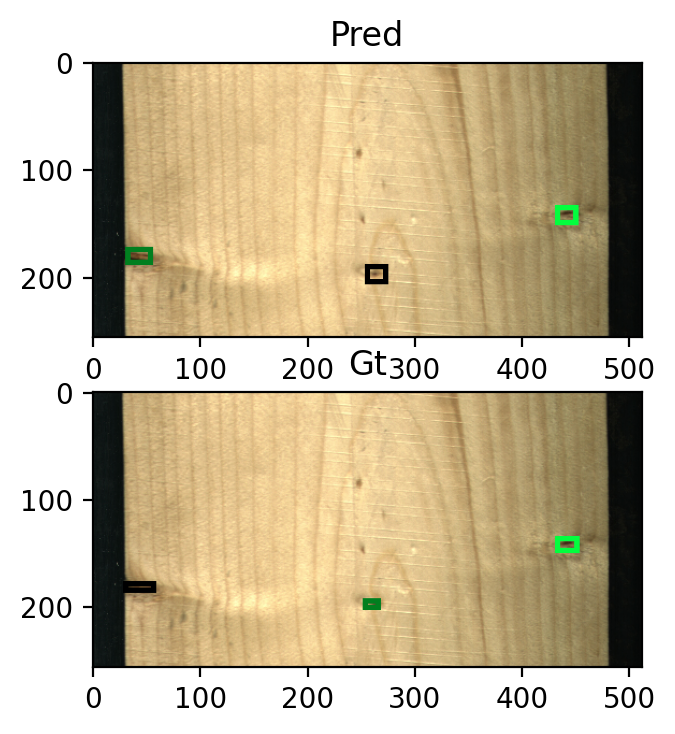

In [32]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox_pred, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [33]:
cm = box_iou(bbox_gt, bbox_pred)
TP = (cm >= 0.5).sum()
FP = len(bbox_pred) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc

tensor(0.6667)

In [34]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))

for idx in range(len(test_data)):
  image = test_data[idx][0]
  target = test_data[idx][1]
  rec = model(image.unsqueeze(0).to(device))
  rec = rec[0]

  nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
  bbox_pred = rec['boxes'][nms_idx].cpu()
  labels_pred = rec['labels'][nms_idx].cpu()

  bbox_gt = target['boxes']
  labels_gt = target['labels']

  cm = box_iou(bbox_gt, bbox_pred)
  box_TP = (cm>0.5).sum()
  box_FP = len(bbox_pred) - box_TP
  box_FN = len(bbox_gt) - box_TP

  box_precision = box_TP/(box_TP + box_FP + eps)
  box_recall = box_TP/(box_TP + box_FN + eps)

  box_precisions.append(box_precision)
  box_recalls.append(box_recall)

  gt2 = labels_gt[cm.argmax(dim=0)]
  for i in range(len(gt2)):
    cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

In [45]:
with open(os.path.join('Classification_matrix', f'{modelname}_FRCNN.npy'), 'wb') as f:
  np.save(f, cls_cm)

In [44]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
print(f'class precision: {cls_precision.mean():.4f}, class recall: {cls_recall.mean():.4f}')

class precision: 0.3432, class recall: 0.3033


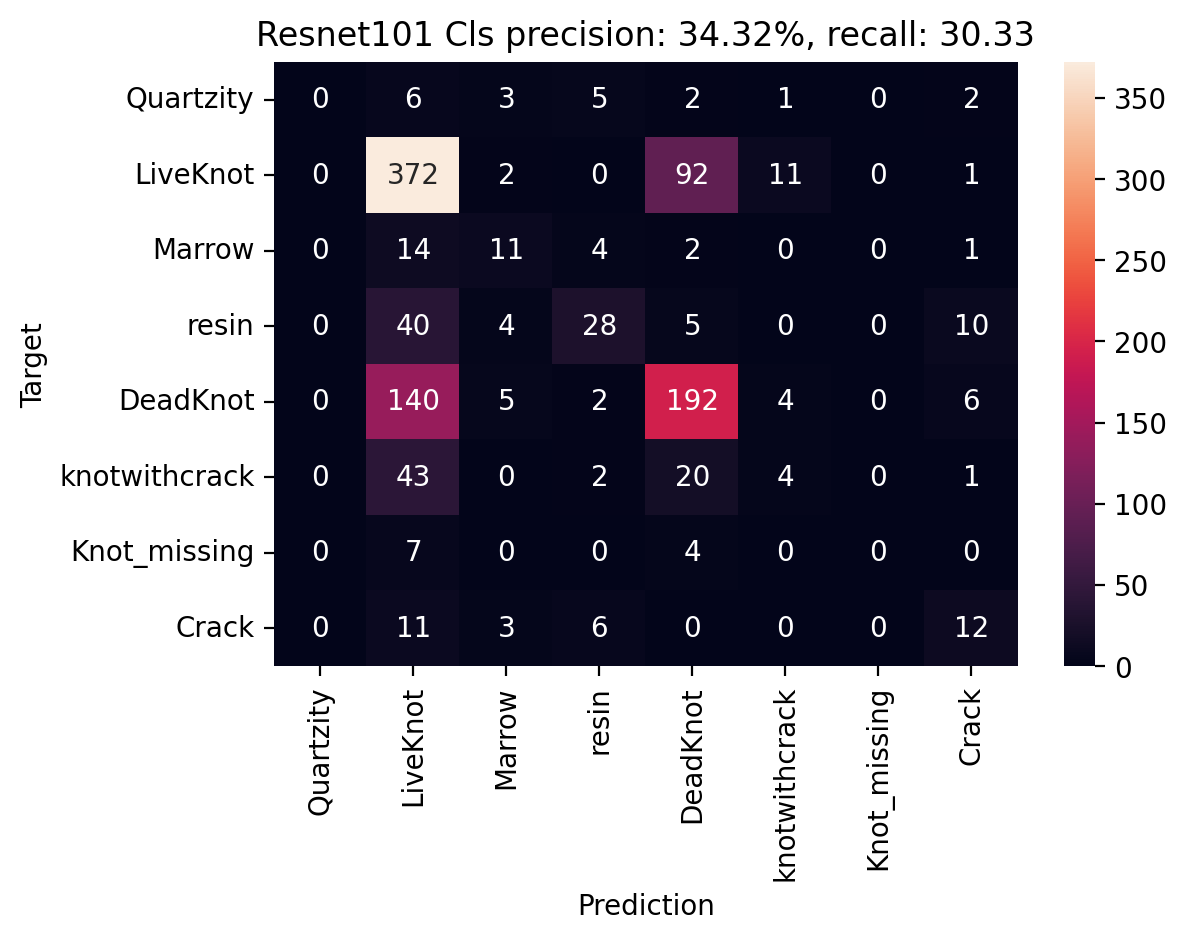

In [37]:
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'{modelname} Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}')
plt.savefig(os.path.join('Classification_matrix', f'{modelname}_FRCNN.png'))
           

In [38]:
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']
df.head(10)

,box_precision,box_recall
0,0.666666,0.666666
1,0.333333,0.500000
2,0.166667,0.333333
3,0.333333,0.999999
4,0.250000,0.333333
5,0.250000,0.250000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.999999,0.500000
9,0.000000,0.000000


In [41]:
print(df['box_precision'].mean())
print(df['box_recall'].mean())

0.5527687259328002
0.6327108337319458


In [46]:
df.to_csv(os.path.join('Validation_csv', save_name.replace('pth', 'csv')))